# Find matches in each pair group (DM, DF), (DM, UM), (DF, UF), (UM, UF), hen analyzing matched of each pair group to get a conclusion

In [3]:
import os
import tqdm
import pickle
import random
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import linalg
from sklearn.utils import resample
from scipy import stats
from functools import reduce

In [ ]:
from pathlib import Path
dataset_dir = Path.cwd() / 'csv_files/yelp'

In [1]:
from pathlib import Path
dataset_dir = Path.cwd() / 'csv_files/stackexchange'

In [46]:
# dis_male = pd.read_csv('disclosed_male.csv',sep='|')
# Load disclosed male
dis_male = pd.read_csv(dataset_dir / 'disclosed_male_l_s_r.csv', sep='|', index_col=0)
dis_male = dis_male.reset_index(drop=True)
dis_male['Sentiment'] = dis_male.Sentiment.apply(lambda x: ast.literal_eval(x)['compound'])

In [47]:
# dis_female = pd.read_csv('disclosed_female.csv',sep='|')
# Load disclosed female
dis_female = pd.read_csv(dataset_dir / 'disclosed_female_l_s_r.csv', sep='|', index_col=0)
dis_female = dis_female.reset_index(drop=True)
dis_female['Sentiment'] = dis_female.Sentiment.apply(lambda x: ast.literal_eval(x)['compound'])

In [48]:
# undis_male = pd.read_csv('undisclosed_male.csv',sep='|')
# Load undisclosed male
undis_male = pd.read_csv(dataset_dir / 'undisclosed_male_l_s_r.csv', sep='|', index_col=0)
undis_male = undis_male.reset_index(drop=True)
undis_male['Sentiment'] = undis_male.Sentiment.apply(lambda x: ast.literal_eval(x)['compound'])

In [49]:
# undis_female = pd.read_csv('undisclosed_female.csv',sep='|')
# Load undisclosed female
undis_female = pd.read_csv(dataset_dir / 'undisclosed_female_l_s_r.csv', sep='|', index_col=0)
undis_female = undis_female.reset_index(drop=True)
undis_female['Sentiment'] = undis_female.Sentiment.apply(lambda x: ast.literal_eval(x)['compound'])

In [106]:
print(dis_male.shape, dis_female.shape, undis_male.shape, undis_female.shape)

(7194, 10) (215, 10) (23527, 10) (5361, 10)


# Legecy code, just for your information

In [ ]:
# cat = undis_male.iloc[0]['categories'].replace('[','').replace(']','').replace('\'','').split(',')

In [ ]:
def getCategoryList(x):
    return reduce(lambda a,b: a+b, ast.literal_eval(x))

In [ ]:
undis_male = undis_male.drop(columns=['category'])

In [ ]:
undis_male.iloc[0]['categories']

In [ ]:
undis_female = undis_female.rename(columns={'categories':'category'})

In [ ]:
undis_female.head()

In [ ]:
undis_female['categories'] = undis_female['category'].apply(lambda x:getCategoryList(x))

In [ ]:
undis_female.head()

In [ ]:
undis_female = undis_female.drop(columns=['category'])

In [ ]:
undis_male = undis_male.rename(columns={'categories':'category'})

In [ ]:
undis_male['categories'] = undis_male['category'].apply(lambda x:getCategoryList(x))
undis_male = undis_male.drop(columns=['category'])

In [ ]:
undis_female.head()

In [ ]:
undis_male.head()

In [ ]:
dis_female = dis_female.rename(columns={'categories':'category'})
dis_female['categories'] = dis_female['category'].apply(lambda x:getCategoryList(x))
dis_female = dis_female.drop(columns=['category'])

In [ ]:
dis_male = dis_male.rename(columns={'categories':'category'})
dis_male['categories'] = dis_male['category'].apply(lambda x:getCategoryList(x))
dis_male = dis_male.drop(columns=['category'])

In [ ]:
def filterCategory(x,category):
    if category in x.lower():
        return True
    return False

# Matching

In [50]:
# choosing one dataset
YELP = False
STACKEXCHANGE = True
if YELP:
    usecols = ['stars','timestamp','length','Grade_level','Sentiment']
if STACKEXCHANGE:
    usecols = ['Reputation','Timestamp','Length','GradeLevel','Sentiment']
    dis_female['Categories'] = 'computer science'
    dis_male['Categories'] = 'computer science'
    undis_female['Categories'] = 'computer science'
    undis_male['Categories'] = 'computer science'

In [51]:
from datetime import datetime
import time
def date_to_timestamp(date_str):
    return time.mktime(datetime.fromisoformat(date_str).timetuple())

In [53]:
undis_female['Timestamp'] = undis_female['Timestamp'].apply(lambda x: date_to_timestamp(x))
undis_male['Timestamp'] = undis_male['Timestamp'].apply(lambda x: date_to_timestamp(x))
dis_female['Timestamp'] = dis_female['Timestamp'].apply(lambda x: date_to_timestamp(x))
dis_male['Timestamp'] = dis_male['Timestamp'].apply(lambda x: date_to_timestamp(x))


In [12]:
# Mahalanobis Distance
def calculateCdist(df_1_s, df_2, cov_inv, usecols=[]):
    cnt = df_2.shape[0]
    slice_len = 250000
    obtained_pairs = []
    similarity_val = []
    n = df_1_s.shape[0]
    if cnt > slice_len:
        slice_cnt = int(cnt / slice_len) + 1
        for i in range(slice_cnt):
            u_s = i * slice_len
            
            if i < slice_cnt - 1:
                u_e = u_s + slice_len
                df_2_s = df_2[u_s:u_e]
            else:
                df_2_s = df_2[u_s:]

#             Y = distance.cdist(df_1_s[['stars', 'timestamp', 'length', 'Grade_level', 'Sentiment']], \
#                                df_2_s[['stars', 'timestamp', 'length', 'Grade_level', 'Sentiment']], \
#                                'mahalanobis', VI=cov_inv)
            # 2 Dimensional array recording the distance of each pair between df_1_s and df_2_s
            Y = distance.cdist(df_1_s[usecols], df_2_s[usecols], 'mahalanobis', VI=cov_inv)
            # the sample from df_2_s closest to sample at a row 
            Y_1 = Y.argmin(axis=1)

            # j: j-th sample from df_1_s
            # Y_1[j]: column index of the closest sample from 2 
            # Y[j, Y_1[j]]: the minimal distance of sample pair (j, Y_1[j])
            # i: slice count
            min_y = [(Y_1[j], Y[j, Y_1[j]], i) for j in range(n)]
            obtained_pairs.append(min_y)

        # obtaining the matched set
        matched_set = []
        for i in range(n):
            for ind, val, s in sorted(list(zip(*obtained_pairs))[i], key=lambda x:x[1]):
                pos = s * slice_len + ind
                matched_set.append(pos)
                similarity_val.append(val)
                break
        
        return matched_set, similarity_val
    else:
        Y = distance.cdist(df_1_s[usecols], df_2[usecols], 'mahalanobis', VI=cov_inv)
        Y_1 = Y.argmin(axis=1)
        
        for i in range(Y.shape[0]):
            similarity_val.append(Y[i, Y_1[i]])
        
        return Y_1, similarity_val

In [40]:
DISCLOSED_MALE = 0
DISCLOSED_FEMALE = 1
UNDISCLOSED_MALE = 2
UNDISCLOSED_FEMALE = 3
def findMatchAllPairs(d_m, d_f, u_m, u_f, sample_size=None):
    total_size =  d_m.shape[0] + d_f.shape[0] + u_m.shape[0] + u_f.shape[0]
    if sample_size is None:
        sample_size = total_size
    elif sample_size > total_size:
        raise Exception('sample size beyond the number of population.')
        
    print(sample_size)
    pairs = {}
    
    if 'group' not in d_m.columns:
        d_m.insert(0,'group', DISCLOSED_MALE)
    if 'group' not in d_f.columns:
        d_f.insert(0,'group', DISCLOSED_FEMALE)
    if 'group' not in u_m.columns:
        u_m.insert(0,'group', UNDISCLOSED_MALE)
    if 'group' not in u_f.columns:
        u_f.insert(0,'group', UNDISCLOSED_FEMALE)
    
    all_data = pd.concat([d_m, d_f, u_m, u_f])
    
    if sample_size is None:
        saple_n = all_data
    else:
        sample_n = all_data.sample(sample_size)
    
    samp_0 = sample_n[sample_n['group'] == DISCLOSED_MALE]
    samp_1 = sample_n[sample_n['group'] == DISCLOSED_FEMALE]
    samp_2 = sample_n[sample_n['group'] == UNDISCLOSED_MALE]
    samp_3 = sample_n[sample_n['group'] == UNDISCLOSED_FEMALE]
    
    print(f'sample DM - {len(samp_0)}, sample DF - {len(samp_1)}, \
    sample UM - {len(samp_2)}, sample UF - {len(samp_3)}')
    
    data = [(samp_0, DISCLOSED_MALE), (samp_1, DISCLOSED_FEMALE), (samp_2, UNDISCLOSED_MALE), (samp_3, UNDISCLOSED_FEMALE)]
    
    for i in range(3):
        samp_treatment, label_treatment = data[i]
        popln_treatment = all_data[all_data['group'] == label_treatment]
        
        for j in range(i+1, 4):
            samp_control, label_control = data[j] 
            popln_control = all_data[all_data['group'] == label_control]

            pop_size = popln_treatment.shape[0] + popln_control.shape[0]
            
            if pop_size < 1000000:
                m = pop_size
            else:
                m = 1000000

            all_sample = pd.concat([popln_treatment, popln_control])
            cov = np.cov(all_sample[usecols].sample(m).values, rowvar=False)
            cov_inv = linalg.inv(cov)

            print('covariance matrix obtained')
            
            Y_1, similarity_1 = calculateCdist(samp_treatment, popln_control, cov_inv) 
            pair_0_0 = [samp_treatment.iloc[i] for i in range(samp_treatment.shape[0])]
            pair_1_0 = [popln_control.iloc[i] for i in Y_1]
            pairs[str(label_treatment) + '-' + str(label_control)] = list(zip(pair_0_0, pair_1_0)) 
            
            Y_1,similarity_2 = calculateCdist(samp_control, popln_treatment, cov_inv)
            pair_0_1 = [popln_treatment.iloc[i] for i in Y_1]
            pair_1_1 = [samp_control.iloc[i] for i in range(samp_control.shape[0])]
            pairs[str(label_control) + '-' + str(label_treatment)] = list(zip(pair_0_1, pair_1_1))
                   
    return pairs  #,similarity_1,similarity_2                             

# Example of a specific category

In [ ]:
category = 'restaurants'

In [ ]:
def filterCategory(x,category):
    if category in x.lower():
        return True
    return False
dis_male_c = dis_male[dis_male['categories'].apply(lambda x:filterCategory(x,category))]

In [ ]:
dis_male_c.head()

In [ ]:
dis_female_c = dis_female[dis_female['categories'].apply(lambda x:filterCategory(x,category))]
undis_male_c = undis_male[undis_male['categories'].apply(lambda x:filterCategory(x,category))]
undis_female_c = undis_female[undis_female['categories'].apply(lambda x:filterCategory(x,category))]

In [ ]:
dis_female_c.count()

In [ ]:
pairs_all = findMatchAllPairs(dis_male_c,dis_female_c,undis_male_c,undis_female_c, 40000)

In [ ]:
pairs = pairs_all
pairs.keys()

# Iterating over all categories

In [17]:
def filterCategory(x,category):
    if category in x.lower():
        return True
    return False

In [10]:
import json
correlated_restaurants = False
if correlated_restaurants:
    with open('correlated_categories.json') as json_file:
        categories = json.load(json_file)
else:
    with open('top_n_correlated_categories.json') as json_file:
        categories = json.load(json_file)
    categories = list(categories.keys())
print(categories)

['sewing & alterations', 'self storage', 'carpet cleaning', 'oral surgeons', "men's hair salons", 'restaurants']


In [54]:
if 'group' not in dis_male.columns:
    dis_male.insert(0, 'group', DISCLOSED_MALE)
if 'group' not in dis_female.columns:
    dis_female.insert(0, 'group', DISCLOSED_FEMALE)
if 'group' not in undis_male.columns:
    undis_male.insert(0, 'group', UNDISCLOSED_MALE)
if 'group' not in undis_female.columns:
    undis_female.insert(0, 'group', UNDISCLOSED_FEMALE)
# run n times 
sample_times = 1
for i in range(0, sample_times): # one sample enough
#     for category in categories:
    for category in ['computer science']:
        print(f'category - {category}')
        
        d_m_c = dis_male[dis_male['Categories'].apply(lambda x:filterCategory(x, category))]
        d_f_c = dis_female[dis_female['Categories'].apply(lambda x:filterCategory(x, category))]
        u_m_c = undis_male[undis_male['Categories'].apply(lambda x:filterCategory(x, category))]
        u_f_c = undis_female[undis_female['Categories'].apply(lambda x:filterCategory(x, category))]

        pairs = findMatchAllPairs(d_m_c, d_f_c, u_m_c, u_f_c)
    
        path = dataset_dir / ('category_pairs/sample_' + str(i))
        abs_file = path / (category + '.pickle')
        if not path.exists():                                    
            path.mkdir(parents=True)
        with open(abs_file, 'wb+') as ft:
            pickle.dump(pairs, ft)
    
    print(f'finished sample - {i}')

category - computer science
36297
sample DM - 7194, sample DF - 215,     sample UM - 23527, sample UF - 5361
covariance matrix obtained


/home/yafei/.conda/envs/ma/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
covariance matrix obtained
finished sample - 0


In [55]:
def perIncr(x,y):
    return (x-y) / min([x,y]) * 100

In [56]:
def calculateMean(h):
    return np.mean([x[0] for x in h]), np.mean([x[1] for x in h])

In [68]:
def getHelfulnessScore(pairs,keys):
    h1 = [(m_1.Score, m_2.Score) for m_1, m_2 in pairs[keys[0]]]
    h2 = [(m_1.Score, m_2.Score) for m_1, m_2 in pairs[keys[1]]]
    return h1, h2

In [58]:
def calculateMetric(pairs, key=None, bootstrap=False):
    res = {}

    for i in range(3):
        for j in range(i + 1, 4):
            key_1 = str(i) + '-' + str(j)
            key_2 = str(j) + '-' + str(i)
            
            h1, h2 = getHelfulnessScore(pairs, (key_1, key_2))
            #total = h1 + h2
            est = []
            if bootstrap:
                for _ in range(1000):
                    total_set = h1 + h2 
                    bootstrap_set = resample(total_set)
                    h_s_1, h_s_2 = calculateMean(bootstrap_set)
                    est.append(perIncr(h_s_1, h_s_2))
                
                res[key_1] = (np.mean(est), stats.sem(est), np.std(est))
            else:
                h_s_1, h_s_2 = calculateMean(h1 + h2)
                res[key_1] = perIncr(h_s_1, h_s_2)
                
    return res, est#,total   

# [optional] connect to the part Example of a specific category

In [ ]:
res, est = calculateMetric(pairs, bootstrap=True)

In [ ]:
est, np.mean(est)

In [ ]:
len(pairs['2-3'])

In [ ]:
pairs['3-2'][0]

In [ ]:
total[3666]

In [ ]:
res.keys()

In [ ]:
with open('category_pairs/sample_1/Books.pickle','rb') as fs:
    pairs = pickle.load(fs)

In [ ]:
pairs.keys()

In [ ]:
calculateMetric(pairs)

# connect to the part iterating over all categories
# [deprecated] sampling without bootstrap

In [ ]:
# categories = ['Books','Electronics','CDs & Vinyl','Clothing, Shoes & Jewelry','Home & Kitchen',\
#              'Kindle Store','Sports & Outdoors','Cell Phones & Accessories', 'Toys & Games','Games','Literature & Fiction',\
#              'Beauty','Health & Personal Care','Movies','Computers']

all_results = {}
for category in tqdm.tqdm(categories):

    results = {'0-1':[], '0-2':[], '0-3':[], '1-2':[], '1-3':[], '2-3':[]}
    
    for _ in range(0, 1):
        path = 'category_pairs/sample_' + str(_) + '/' + category + '.pickle'
        with open(path, 'rb') as fs:
            pairs = pickle.load(fs)
        res, _ = calculateMetric(pairs, boostrap=)
        for key in res:
            results[key].append(res[key])
    
    mean_res = {}
    for key in results.keys():
        mean_res[key] = (np.mean(results[key]), np.std(results[key])) # scipy.stats.sem(results[key])
    
    all_results[category] = mean_res
    
    print(f'done for {category}')

In [ ]:
# categories = ['Books','Electronics','CDs & Vinyl','Clothing, Shoes & Jewelry','Home & Kitchen',\
#              'Kindle Store','Sports & Outdoors','Cell Phones & Accessories', 'Toys & Games','Games','Literature & Fiction',\
#              'Beauty','Health & Personal Care','Movies','Computers']

all_results = {}
for category in tqdm.tqdm(categories):

    results = {'0-1':[], '0-2':[], '0-3':[], '1-2':[], '1-3':[], '2-3':[]}
    
    for _ in range(13, 15):
        path = 'category_pairs/sample_' + str(_) + '/' + category + '.pickle'
        with open(path, 'rb') as fs:
            pairs = pickle.load(fs)
        res, _ = calculateMetric(pairs)
        for key in res:
            results[key].append(res[key])
    
    mean_res = {}
    for key in results.keys():
        mean_res[key] = (np.mean(results[key]),  scipy.stats.sem((results[key]))
    
    all_results[category] = mean_res
    
    print(f'done for {category}')

In [ ]:
all_results.keys()

In [ ]:
key = '0-2'
mean_results = []
for category in categories:
    print(category, all_results[category][key])
    mean_results.append(all_results[category][key][0])
mean = sum(mean_results) / len(mean_results)    
mean_results.append(mean)

# Plot initialization

In [62]:
if YELP:
    cat_plot = ('sewing & alterations', 'self storage', 'carpet cleaning', 
                'oral surgeons', "men's hair salons", 'restaurants', 'overall')
if STACKEXCHANGE:
    cat_plot = ('computer science', 'overall')

In [63]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt

In [104]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#mpl.style.use('classic')
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] =  12, 10
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['axes.linewidth'] = 2.5
#plotResults(per_incr,std_err,'UF','UM')

ind = np.arange(5)    
width = 0.35 

In [101]:
def plotResults(per_incr, grp_1, grp_2, std_err=None, dir_=''):
    #plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(cat_plot))
    
    hatch, color, fill = [], [], []
    for i in per_incr:
        if i < 0:
            hatch.append('xxx')
            color.append('b')
            fill.append(False)
        else:
            hatch.append('xxx')
            color.append('b')
            fill.append(True)

    print(len(y_pos), len(per_incr))        
    barlist = ax.barh(y_pos, per_incr, align='center',xerr=std_err)
    for i,thisbar in enumerate(barlist.patches):
        thisbar.set_hatch(hatch[i])
        thisbar.set_color(color[i])
        thisbar.set_fill(fill[i])
    
    majorLocator = MultipleLocator(20)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(2.5)

    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)

    # for the minor ticks, use no labels; default NullFormatter
    ax.xaxis.set_minor_locator(minorLocator)
    ax.set_yticks(y_pos)
    plt.ylim(-1, 16)
    ax.set_yticklabels(cat_plot)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Advantage (%)')
#     plt.xlim(-50,50)
#     x_pos = np.arange(-50, 60, step=10)
    plt.xlim(-100, 100)
#     xticklabels = [50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50]
    xticklabels = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    x_pos = np.arange(-100, 110, step=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xticklabels)
    plt.axvline(0, color='black')
    plt.axhline(14.58, color='black')
    plt.text(-40, 0, grp_1, fontsize=23)
    plt.text(35, 0, grp_2, fontsize=23)
    plt.grid(linestyle='--')
    ax.get_yticklabels()[-1].set_color("m")
    title = grp_1 + '_' + grp_2 + '.jpg'
    plt.tight_layout()
    plt.savefig(dir_ + '/' + title, dpi=250)
    #plt.savefig('plotNatural/'+title, format='svg', dpi=1200)
    plt.show()

# Bootstrap sampling

In [69]:
# categories = ['Books','Electronics','CDs & Vinyl','Clothing, Shoes & Jewelry','Home & Kitchen',\
#              'Kindle Store','Sports & Outdoors','Cell Phones & Accessories', 'Toys & Games','Games','Literature & Fiction',\
#              'Beauty','Health & Personal Care','Movies','Computers']

all_res = []
sample_times = 1
for i in range(0, sample_times):
    all_results = {}
#     for category in categories:
    for category in ['computer science']:
        bootstrap_res = {}
        path = dataset_dir / ('category_pairs/sample_' + str(i) + '/' + category + '.pickle')
        with open(path, 'rb') as fs:
            pairs = pickle.load(fs)
        res, _ = calculateMetric(pairs, bootstrap=True)
        # scipy.stats.sem
        all_results[category] = res

        print(f'done for {category}')
    
    print(f'sample {i} finished')
    all_res.append(all_results) 

done for computer science
sample 0 finished


In [70]:
all_results.keys()

dict_keys(['computer science'])

In [73]:
if STACKEXCHANGE:
    categories = ['computer science']
def getResults(res, key):
    val = []
    std_err = []
    for category in categories:
        val.append(res[category][key][0])
        std_err.append(res[category][key][1])

    mean = np.mean(val)
    val.append(mean)
    std_err.append(0)
    return val, std_err

In [74]:
# '0-1', '0-2', '2-3', '1-3'
# DISCLOSED_MALE = 0
# DISCLOSED_FEMALE = 1
# UNDISCLOSED_MALE = 2
# UNDISCLOSED_FEMALE = 3
val, std_err = getResults(all_res[0], '0-1')

In [99]:
print(val, std_err)

[308.36520476295266, 308.36520476295266] [0.27750731663294187, 0]


2 2


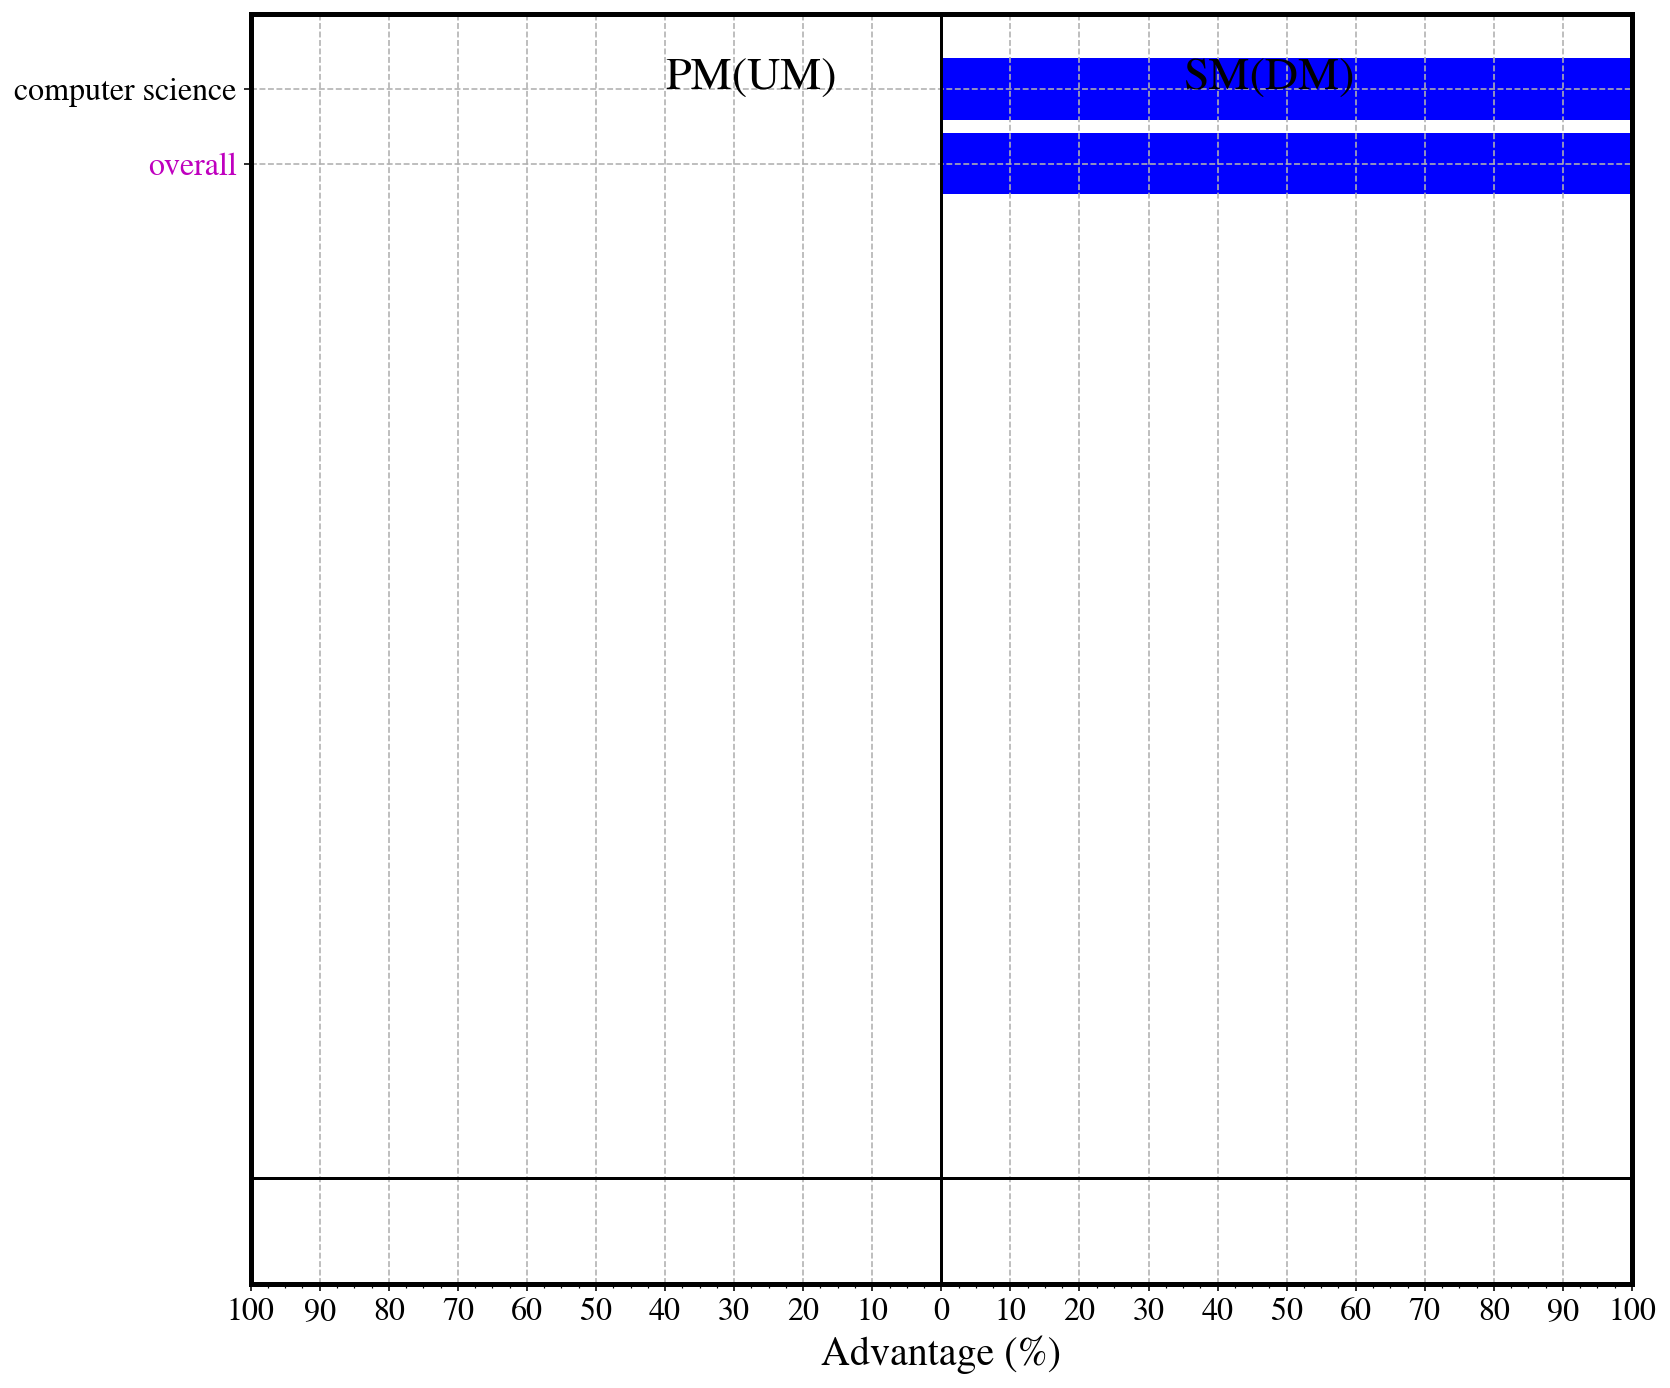

In [105]:
# PM: Performative Male (undisclosed), SM: Singnal Male (disclosed)
plotResults(val, 'PM(UM)', 'SM(DM)', std_err=std_err, dir_='./')

2 2


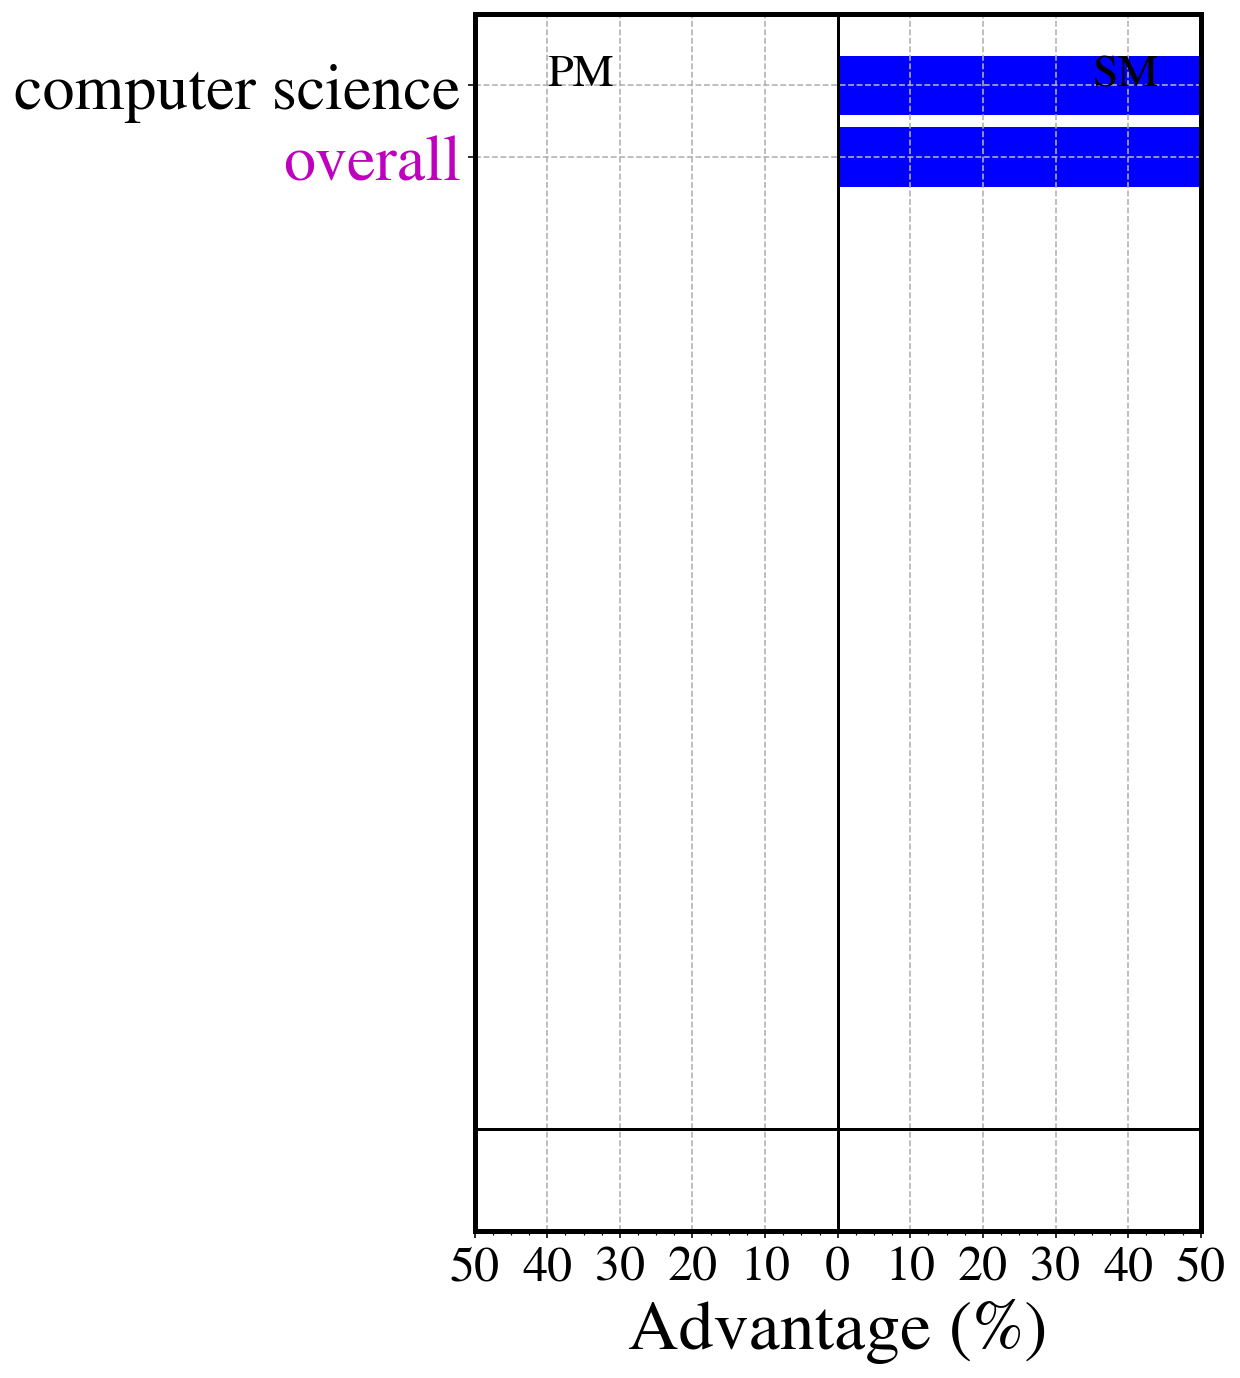

In [76]:
val, std_err = getResults(all_res[0], '0-2')
plotResults(val, 'PM', 'SM', std_err=std_err, dir_='./')

2 2


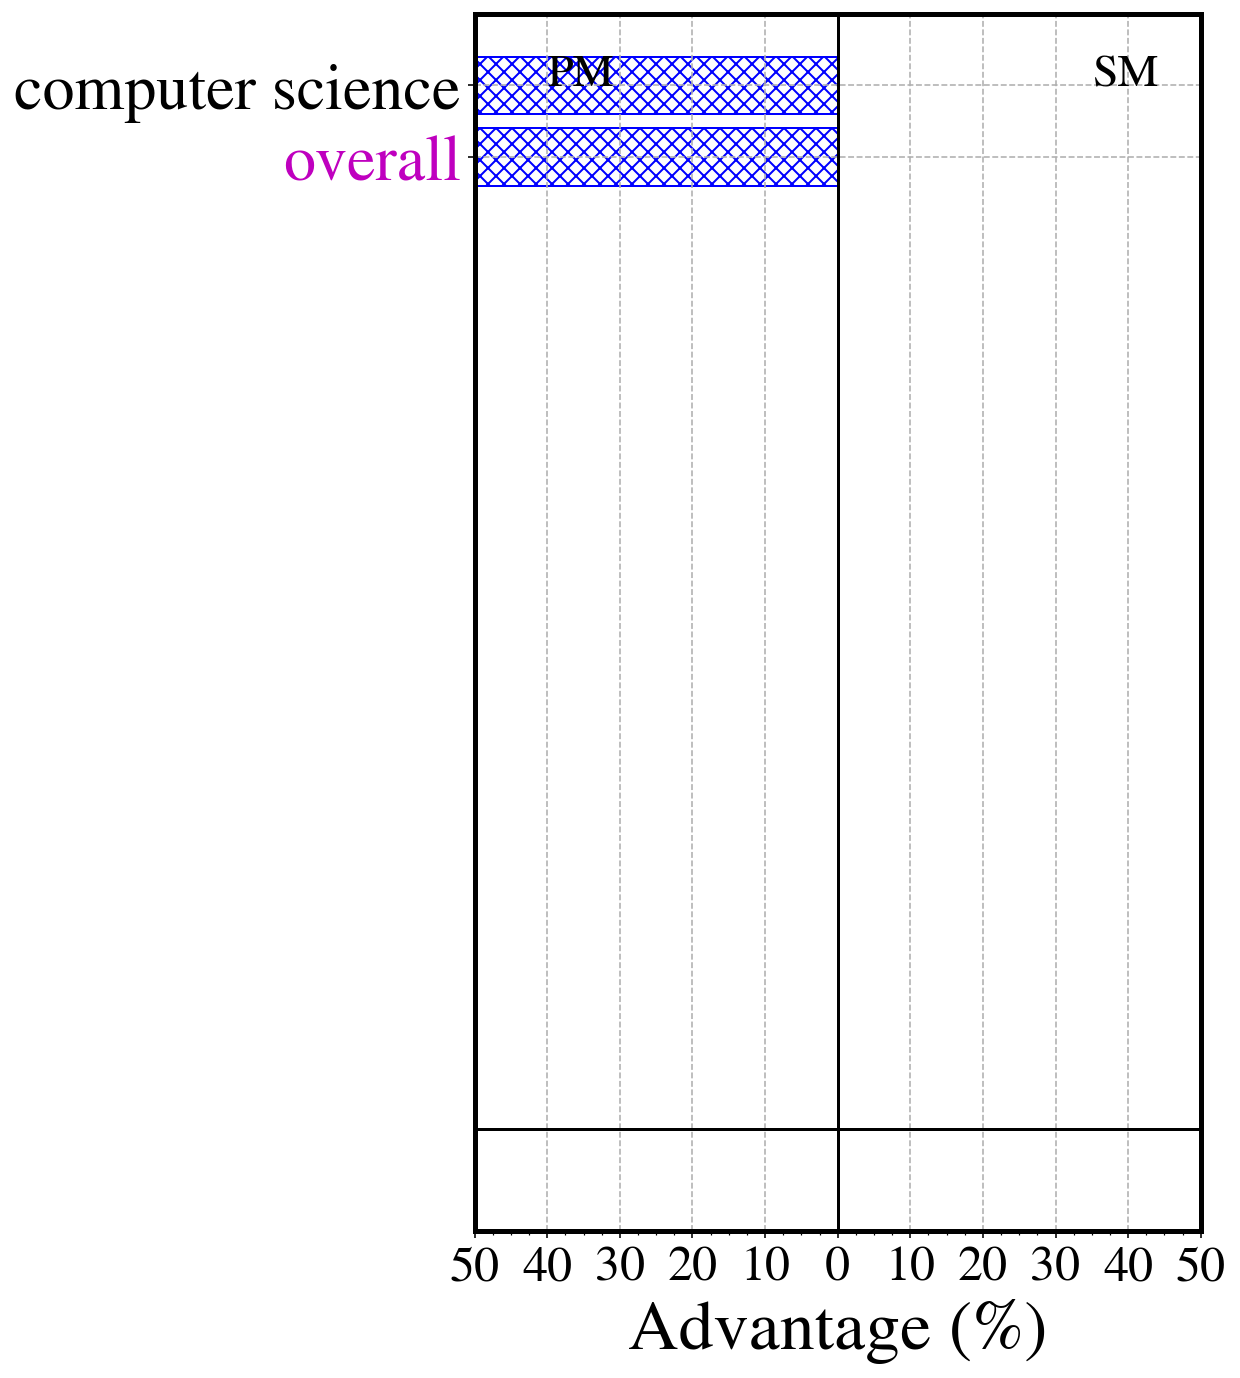

In [77]:
val, std_err = getResults(all_res[0], '2-3')
plotResults(val, 'PM', 'SM', std_err=std_err, dir_='./')

2 2


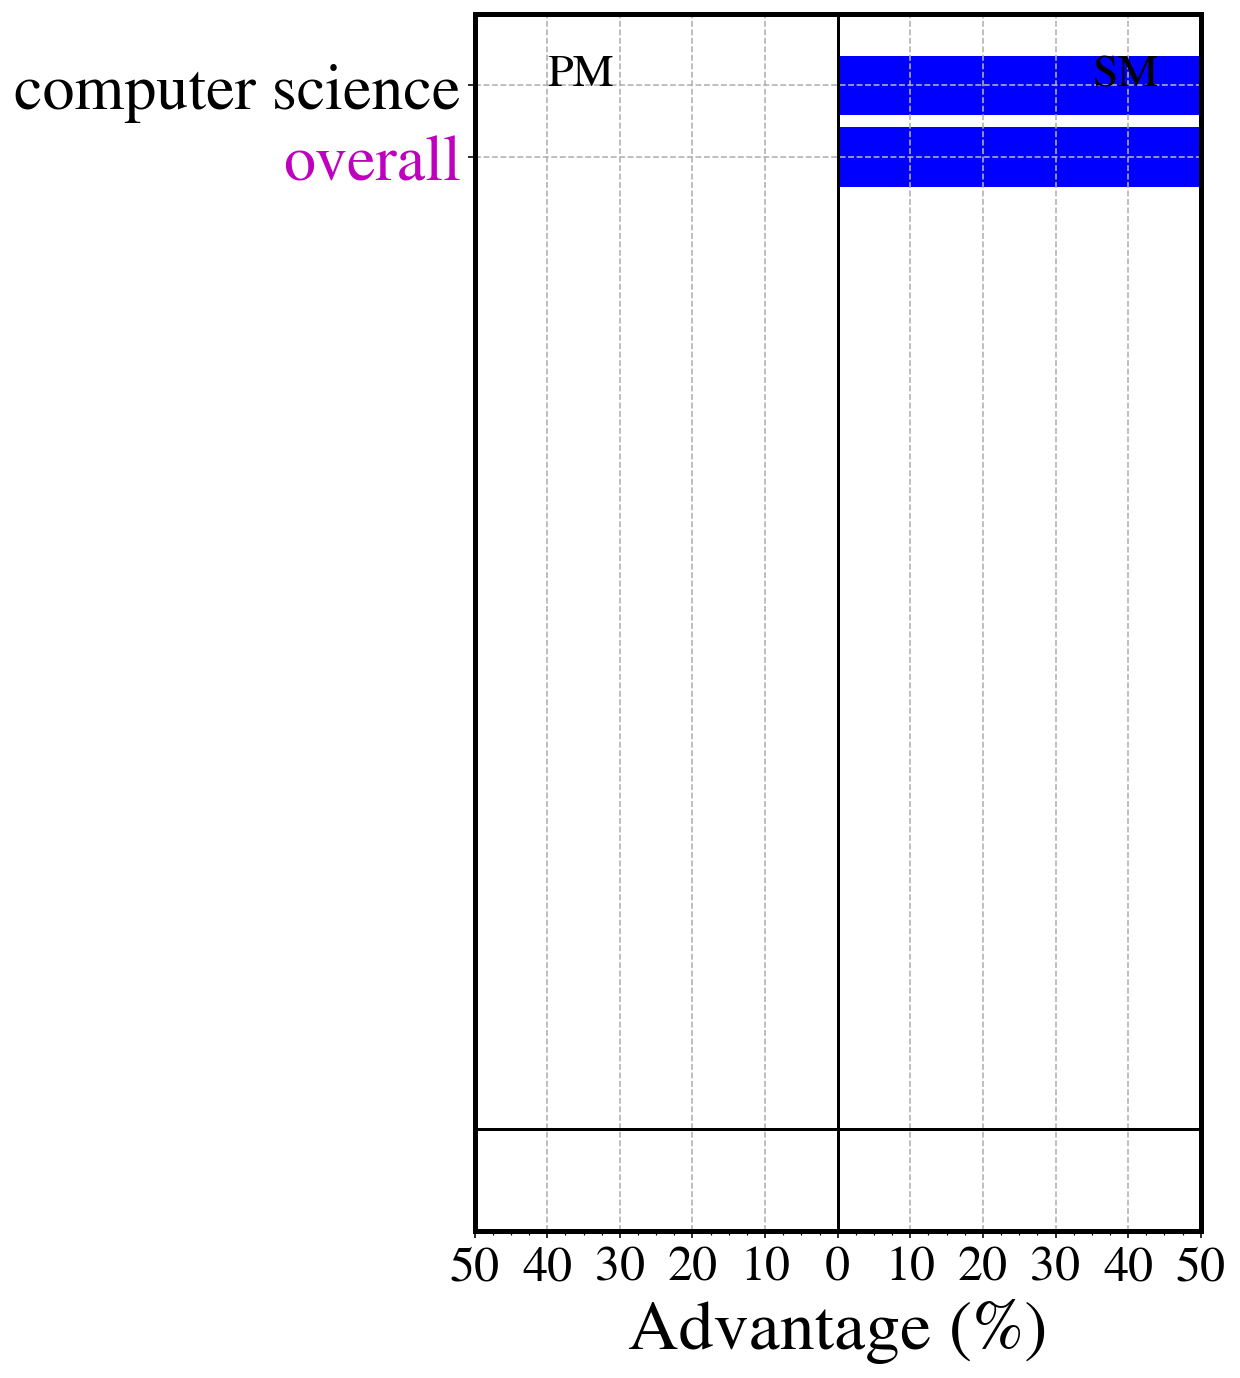

In [78]:
val, std_err = getResults(all_res[0], '1-3')
plotResults(val, 'PM', 'SM', std_err=std_err, dir_='./')

# [deprecated] Calculate covariate distribution

In [ ]:
categories = ['Books','Electronics','CDs & Vinyl','Clothing, Shoes & Jewelry','Home & Kitchen',\
             'Kindle Store','Sports & Outdoors','Cell Phones & Accessories', 'Toys & Games','Games','Literature & Fiction',\
             'Beauty','Health & Personal Care','Movies','Computers']

In [ ]:
category = 'Books'

In [ ]:
path = 'category_pairs/sample_3/' + category + '.pickle'
with open(path,'rb') as fs:
    pairs = pickle.load(fs)

In [ ]:
pairs.keys()

In [ ]:
pairs['1-0'][0]

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
def createDistribution(lst):
    u_el = list(set(lst))
    u_el.sort()
    dist = []
    for el in u_el:
        el_cnt = lst.count(el)
        dist.append(el_cnt)
    s = sum(dist)
    return u_el, [i/s for i in dist]

In [ ]:
def calcCovariateHist(pairs,x_label=None,covariate=None):
    keys = ['0-1', '1-0', '2-3', '3-2', '1-3', '3-1', '0-2', '2-0']
    
    confounder = {}
    
    for key in keys:
        for pair in pairs[key]:
            x = pair[0]['group']
            val_x = pair[0][covariate]
            y = pair[1]['group']
            val_y = pair[1][covariate]
            if x not in confounder:
                confounder[x] = []
            if y not in confounder:
                confounder[y] = []
            confounder[x].append(val_x)
            confounder[y].append(val_y)
    
    
    confounder_fil = {}
    confounder_fil[0] = [i for i in confounder[0] if i in range(1,16)]
    confounder_fil[1] = [i for i in confounder[1] if i in range(1,16)]
    confounder_fil[2] = [i for i in confounder[2] if i in range(1,16)]
    confounder_fil[3] = [i for i in confounder[3] if i in range(1,16)]
    
    print(min(confounder_fil[0]),max(confounder_fil[0]))
    print(min(confounder_fil[1]),max(confounder_fil[1]))
    print(min(confounder_fil[2]),max(confounder_fil[2]))
    print(min(confounder_fil[3]),max(confounder_fil[3]))
    
    width = 0.15
    fig, ax = plt.subplots()
    colors = ['b','r','b','r']
    edge_colors = [None,None,'b','r']
    #hatches = ['','','xxx','xxx']
    linestyles = ['-','-','--','--']
    fills = [True,True,False,False]
    labels = ['SM','SW','PM','PW']
    #x_pos = np.arange(1.5,60,step=10)
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels([50,40,30,20,10,0,10,20,30,40,50])
    #print(min(confounder[0]),min(confounder[1]),min(confounder[2]),min(confounder[3]))
    for i in range(4):
        x,dist = createDistribution(confounder_fil[i])
        plt.plot(x,dist,color = colors[i],label = labels[i],linewidth=2,linestyle = linestyles[i])
        #x = [i*width+j for j in x]
        #plt.bar(x,dist,color=colors[i],hatch=hatches[i],fill=fills[i],label=labels[i],width=0.15,edgecolor=edge_colors[i])
    
    index = np.arange(1,16)
    plt.xticks(index + width*1.5, (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15))
    plt.grid(linestyle='--')
    plt.xlabel(x_label)
    plt.ylabel('PMF')
    plt.tight_layout()
    plt.savefig('plotCovariates/'+covariate+'.jpg',dpi=250)
    plt.legend()
    plt.show()

In [ ]:
x = calcCovariateHist(pairs,x_label='Readability',covariate='Grade_level')

In [ ]:
len(x)

In [ ]:
def calcCovariateDist(pairs,t,x_label='Readability',covariate='Grade_level'):
    
    flag = 0
    dists_all = []
    for i in range(4):
        if i!=t:
            if flag==0:
                grp_0_1 = [(m[covariate],n[covariate]) for m,n in pairs[str(t)+'-'+str(i)]]
                #grp_1_0 = [(n[covariate],m[covariate]) for m,n in pairs[str(i)+'-'+str(t)]]
                #grp = grp_0_1 + grp_1_0
                dist = list(zip(*grp_0_1))
            
                dist_0 = list(dist[0])
                dists_all.append(list(dist[1]))
            
            else:
                dists_all.append([n[covariate] for m,n in pairs[str(t)+'-'+str(i)]])
                
            #val,p = ks_2samp(dist_0,dist_1)
            #print(val,p)
            #dist_0.sort()
            #dist_1.sort()
            #y_1 = np.cumsum(dist_0)
            #y_2 = np.cumsum(dist_1)
            
    #y,binEdges=np.histogram(dist_0,bins=100)
    #bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    #plt.plot(bincenters,y,'-',linewidth=2)
    sns.distplot(dist_0,hist=False,rug=True,label='DM',kde_kws={'color':'b','linewidth':2})
    
    colors = ['r','b','r']
    ls = ['-','--','--']
    labels = ['DW','UM','UW']
    
    for i,dist in enumerate(dists_all):

        #y,binEdges=np.histogram(dist,bins=100)
        #bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        #plt.plot(bincenters,y,'-',linewidth=2)
        sns.distplot(dist,hist=False,rug=True,label=labels[i],
                     kde_kws={'color':colors[i],'linestyle':ls[i],'linewidth':2})

    plt.xlabel(x_label)
    plt.ylabel('PDF')
    plt.grid(linestyle='--')
    #plt.xscale('log')
    plt.tight_layout()
    plt.savefig('plotCovariates/'+covariate+'.jpg',dpi=250)
    
            
            
    

In [ ]:
pairs['0-1'][100]

In [ ]:
calcCovariateDist(pairs,0,x_label='Rating',covariate='Rating')

In [ ]:
from scipy.stats import kruskal

In [ ]:
d_m_s = dis_male.sample(1000000)

In [ ]:
u_m_s = undis_male.sample(1000000)

In [ ]:
d_f_s = dis_female.sample(1000000)

In [ ]:
u_f_s = undis_female.sample(1000000)

In [ ]:
kruskal(d_m_s['overall_sentiment'],u_m_s['overall_sentiment'],d_f_s['overall_sentiment'],u_f_s['overall_sentiment'])

In [ ]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#mpl.style.use('classic')
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 32
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] =  9,10
mpl.rcParams['axes.labelsize'] = 35
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['axes.linewidth'] = 2.5

In [ ]:
calcCovariateDist(pairs,0)

In [ ]:
import seaborn as sns